In [1]:
from collections import Counter
import matplotlib.pyplot as plt

# 1. Path to BED file
bed_path = "data/query.bed/query.bed"

# 2. Initialize a counter for fragment lengths
length_counts = Counter()

# 3. Read through the file and compute lengths
with open(bed_path) as f:
    for line in f:
        if line.startswith(("#", "track", "browser")):
            continue  # skip headers or comments
        cols = line.rstrip("\n").split("\t")
        start = int(cols[1])
        end   = int(cols[2])
        length = end - start
        if length > 0:
            length_counts[length] += 1


In [2]:
# Total number of fragments
total_frags = sum(length_counts.values())

# Create lists sorted by fragment length
lengths = sorted(length_counts)
raw_counts = [length_counts[L] for L in lengths]

# Normalize: divide each count by total
norm_freqs = [cnt / total_frags for cnt in raw_counts]


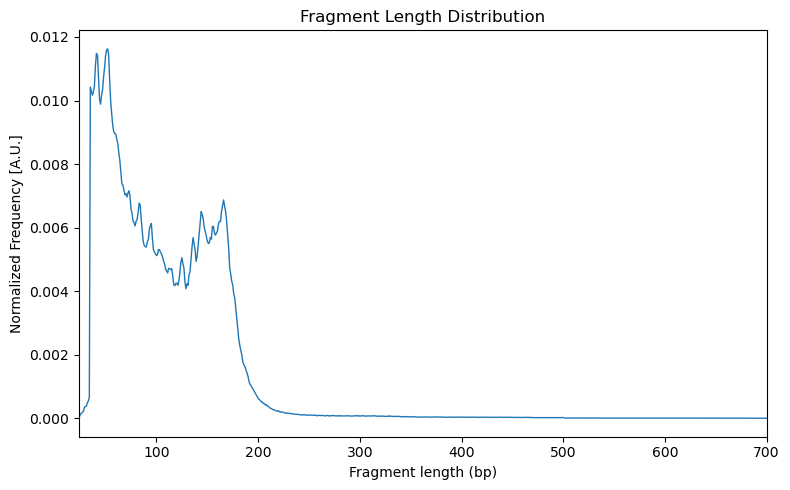

In [3]:
plt.figure(figsize=(8, 5))
plt.plot(lengths, norm_freqs, lw=1)
plt.xlabel("Fragment length (bp)")
plt.ylabel("Normalized Frequency [A.U.]")
plt.title("Fragment Length Distribution")
plt.xlim(min(lengths), max(lengths))
plt.tight_layout()
plt.show()


In [4]:
import gzip
import random
from collections import Counter
import matplotlib.pyplot as plt

reference_hist = "data/reference.hist"   # reference histogram: two columns (length, count)
query_bed_gz   = "data/query.bed.gz"   # gzipped query BED file
output_bed     = "query_rescaled.bed"
seed           = 42                # random seed for reproducibility


In [5]:
ref_counts = Counter()
total_ref = 0
with open(reference_hist) as f:
    for line in f:
        if line.startswith('#') or not line.strip():
            continue
        parts = line.strip().split()
        length = int(parts[0])
        count  = float(parts[1])
        ref_counts[length] = count
        total_ref += count

# normalize reference frequencies
ref_freq = {L: cnt / total_ref for L, cnt in ref_counts.items()}


In [6]:
query_counts = Counter()
with gzip.open(query_bed_gz, 'rt') as f:
    for line in f:
        if line.startswith(("#", "track", "browser")):
            continue
        cols = line.split()[:3]
        start, end = int(cols[1]), int(cols[2])
        length = end - start
        if length > 0:
            query_counts[length] += 1

# total query fragments
total_query = sum(query_counts.values())
# normalize query frequencies
query_freq = {L: cnt / total_query for L, cnt in query_counts.items()}

# p_accept[L] = ref_freq[L] / query_freq[L], capped at 1.0
# lengths missing in ref get p_accept = 0 (drop)
p_accept = {}
for L, qf in query_freq.items():
    rf = ref_freq.get(L, 0.0)
    p = rf / qf if qf > 0 else 0
    p_accept[L] = min(p, 1.0)


In [7]:
random.seed(seed)
kept = 0
with gzip.open(query_bed_gz, 'rt') as fin, open(output_bed, 'w') as fout:
    for line in fin:
        if line.startswith(("#", "track", "browser")):
            fout.write(line)
            continue
        cols = line.strip().split()
        start, end = int(cols[1]), int(cols[2])
        length = end - start
        if length <= 0:
            continue
        if random.random() <= p_accept.get(length, 0.0):
            fout.write(line)
            kept += 1

print(f"Subsampled and wrote {kept} fragments to {output_bed}")


Subsampled and wrote 4770170 fragments to query_rescaled.bed


In [8]:
# Recompute distribution on subsampled data
sub_counts = Counter()
with open(output_bed) as f:
    for line in f:
        if line.startswith(("#", "track", "browser")):
            continue
        cols = line.split()[:3]
        start, end = int(cols[1]), int(cols[2])
        length = end - start
        sub_counts[length] += 1

tot_sub = sum(sub_counts.values())
lengths = sorted(sub_counts)
norm_sub = [sub_counts[L] / tot_sub for L in lengths]
ref_norm = [ref_freq.get(L, 0) for L in lengths]



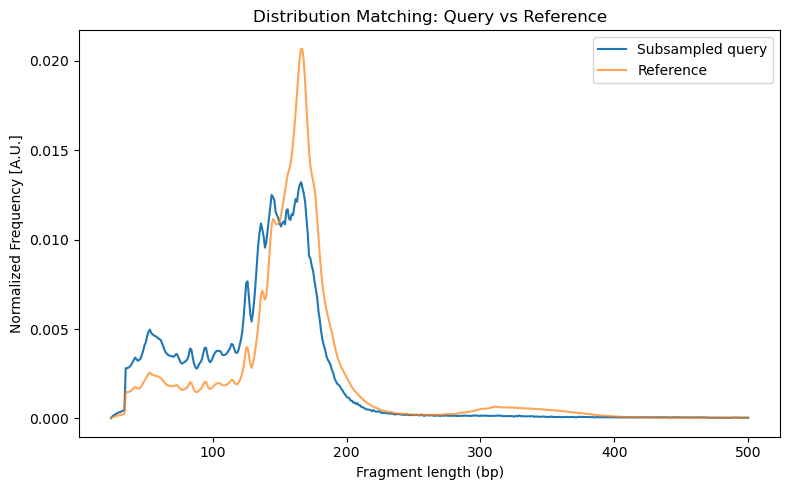

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(lengths, norm_sub, label='Subsampled query')
plt.plot(lengths, ref_norm,  label='Reference', alpha=0.7)
plt.xlabel('Fragment length (bp)')
plt.ylabel('Normalized Frequency [A.U.]')
plt.legend()
plt.title('Distribution Matching: Query vs Reference')
plt.tight_layout()
plt.show()